In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
pip install wandb

  Using cached wandb-0.20.1-py3-none-macosx_11_0_arm64.whl.metadata (10 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached GitPython-3.1.44-py3-none-any.whl.metadata (13 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached PyYAML-6.0.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.33.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached typing_inspection-0.4.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
Using cached wandb-0.20.1-py3-none-macosx_11_0_arm64.whl (22.0 MB)
Using cached pydantic-2.11.7-py3-none-any.whl (444 kB)
Using cached pydantic_core-2.33.2-cp313-cp313-macosx_11_0_arm64.whl (1.8 MB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Using cached click-8.2.1-py3-none-

# Feature engineering

In [2]:
train_df = pd.read_csv("./data/train.csv", index_col='id')

train_df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [3]:
train_df.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


<Axes: title={'center': 'Fertilizer Name Distribution'}, xlabel='Fertilizer Name'>

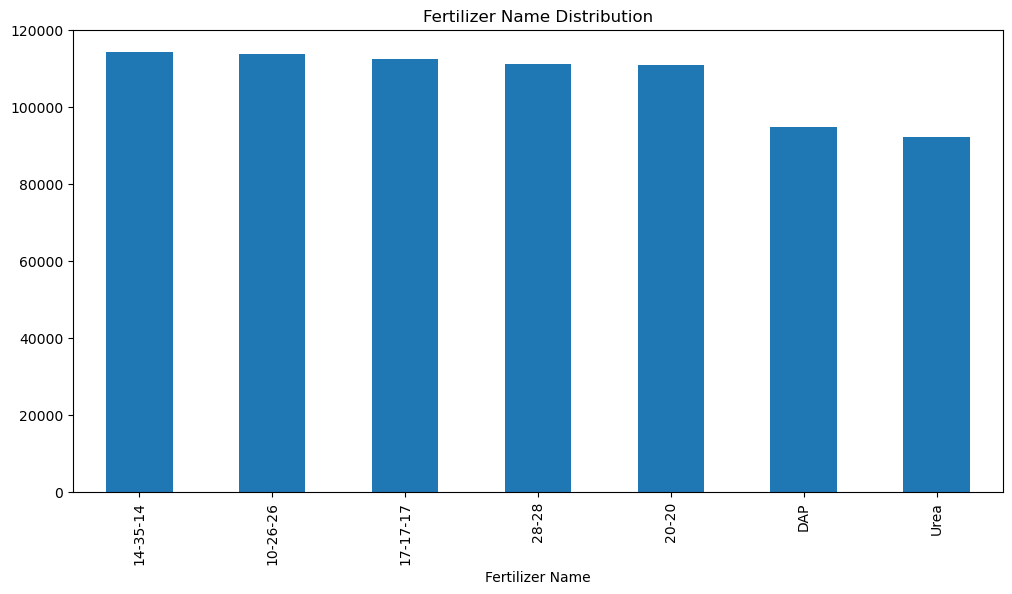

In [4]:
train_df["Fertilizer Name"].value_counts().plot(
    kind="bar", figsize=(12, 6), title="Fertilizer Name Distribution"
)

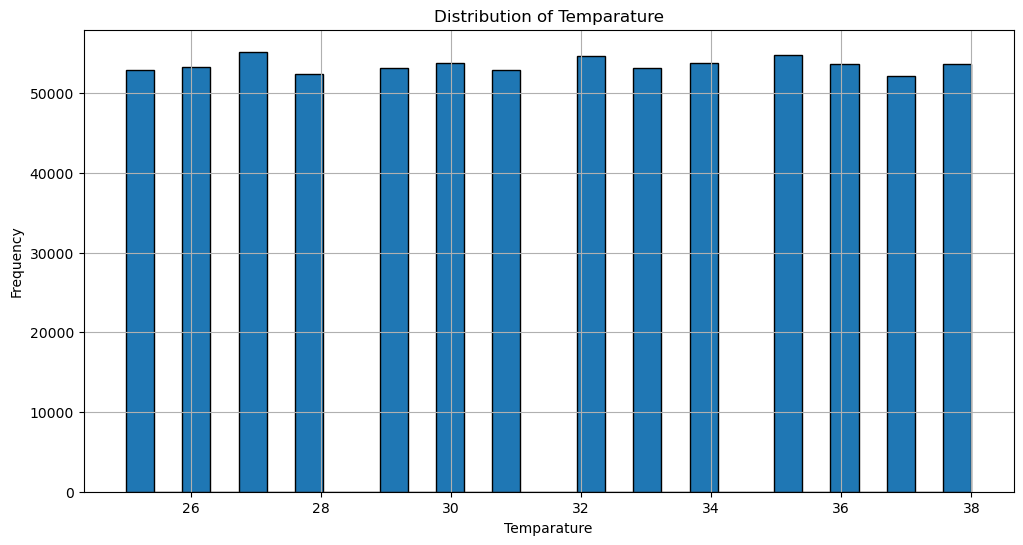

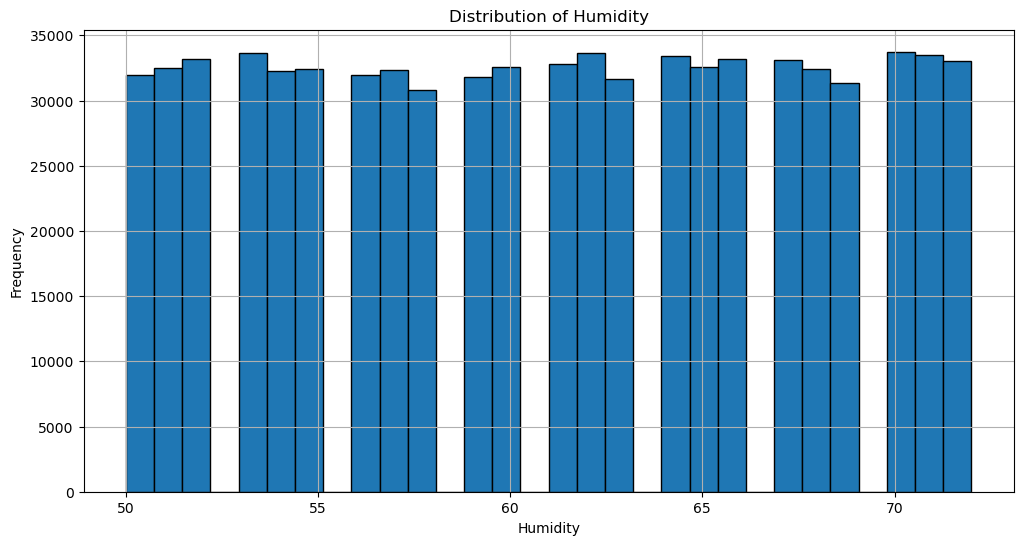

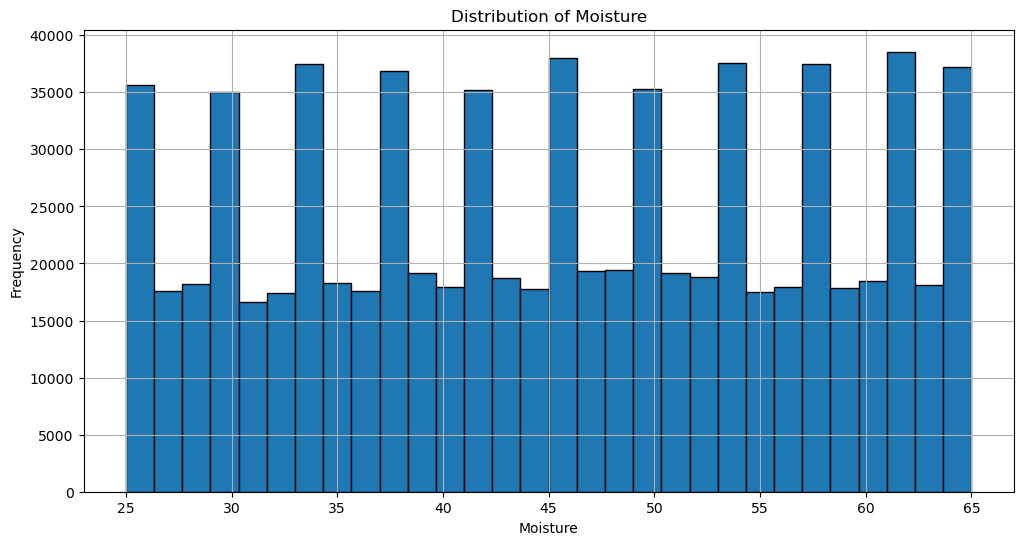

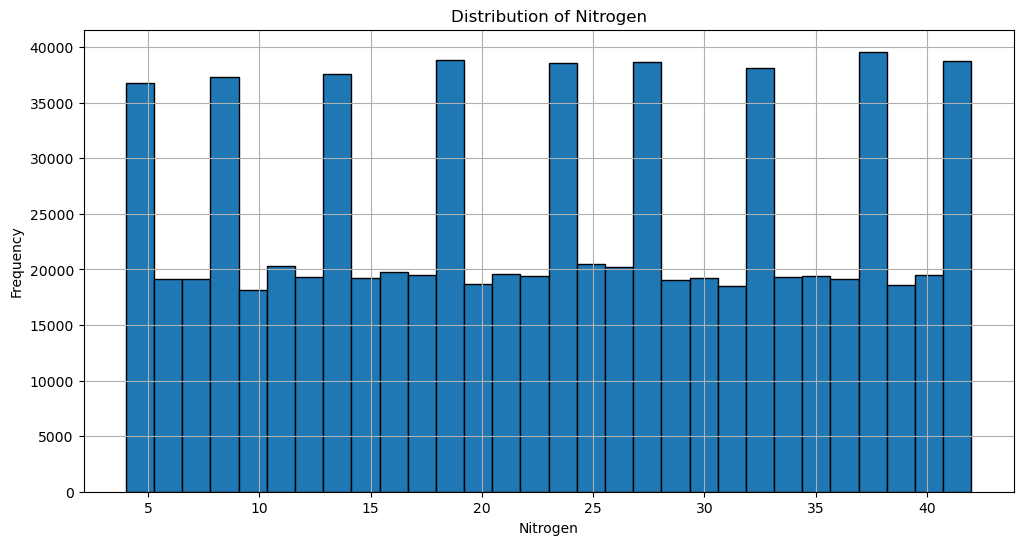

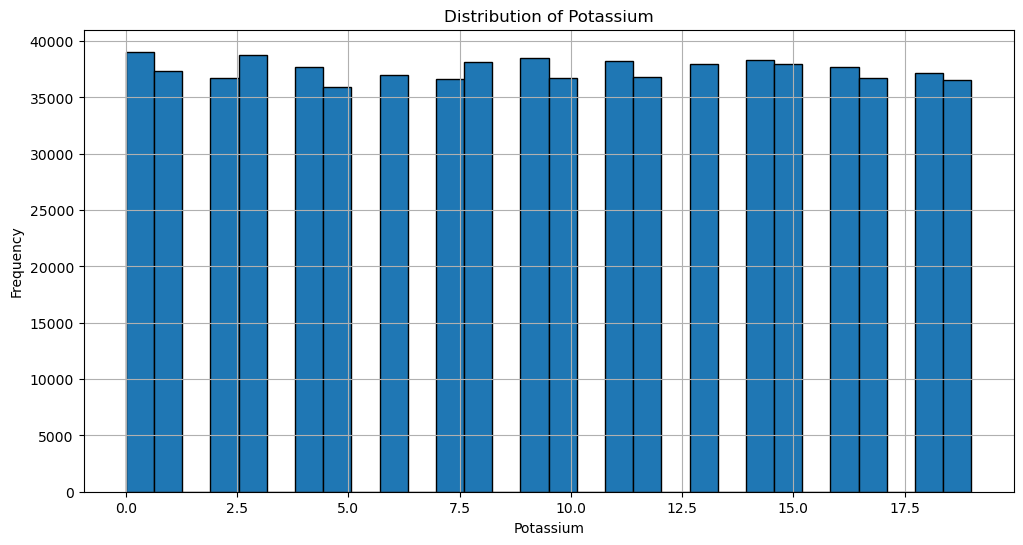

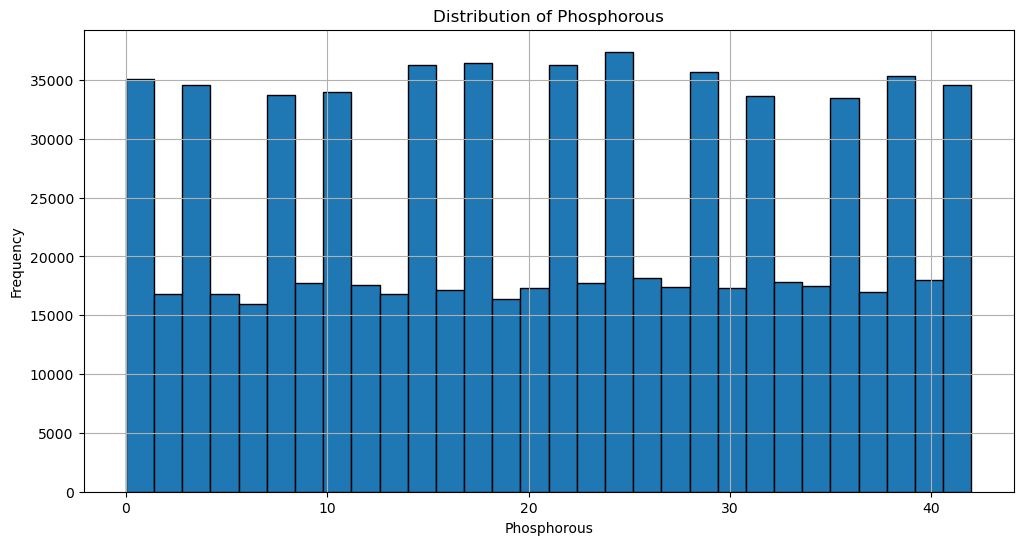

In [5]:
for column in train_df.columns:
    # Plot the distribution of each column if it is numeric
    if pd.api.types.is_numeric_dtype(train_df[column]):
        plt.figure(figsize=(12, 6))
        
        train_df[column].hist(bins=30, edgecolor='black')
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

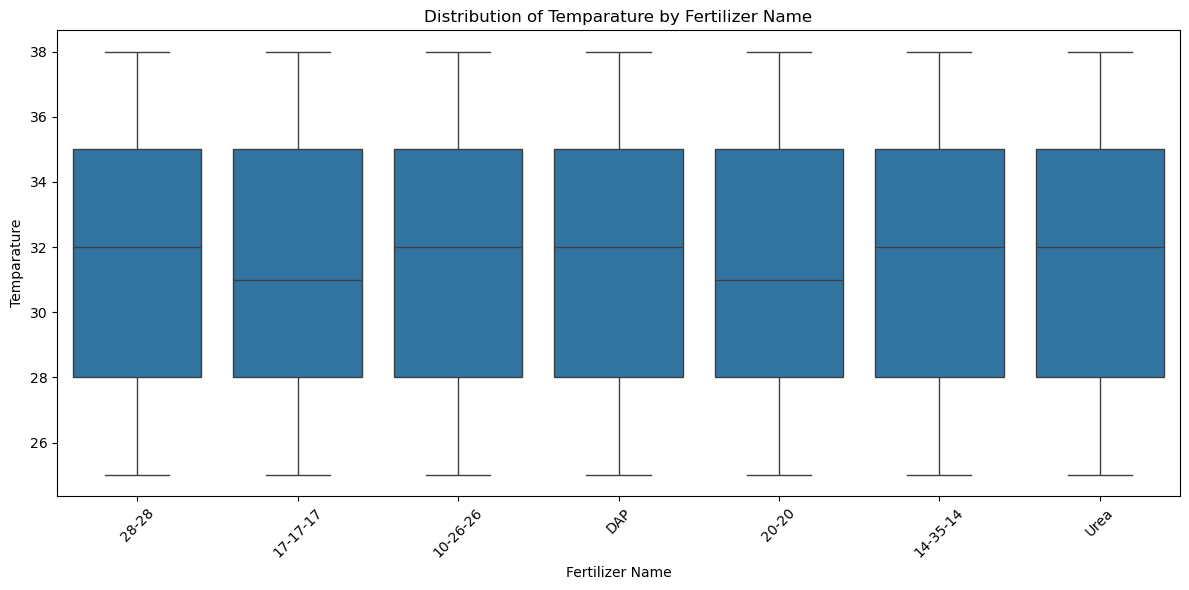

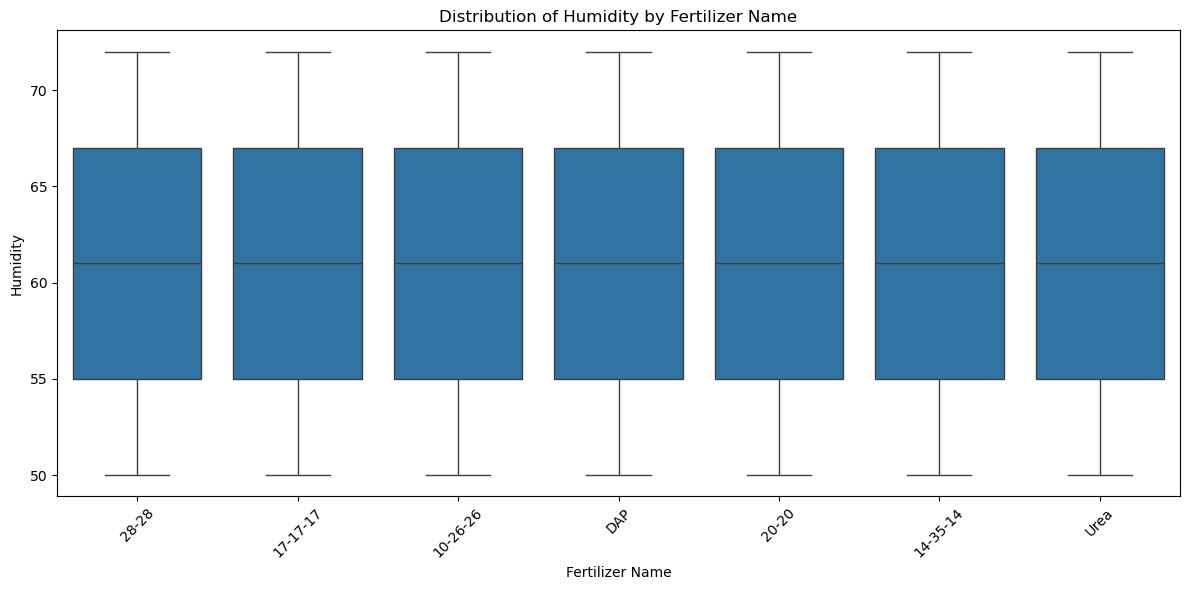

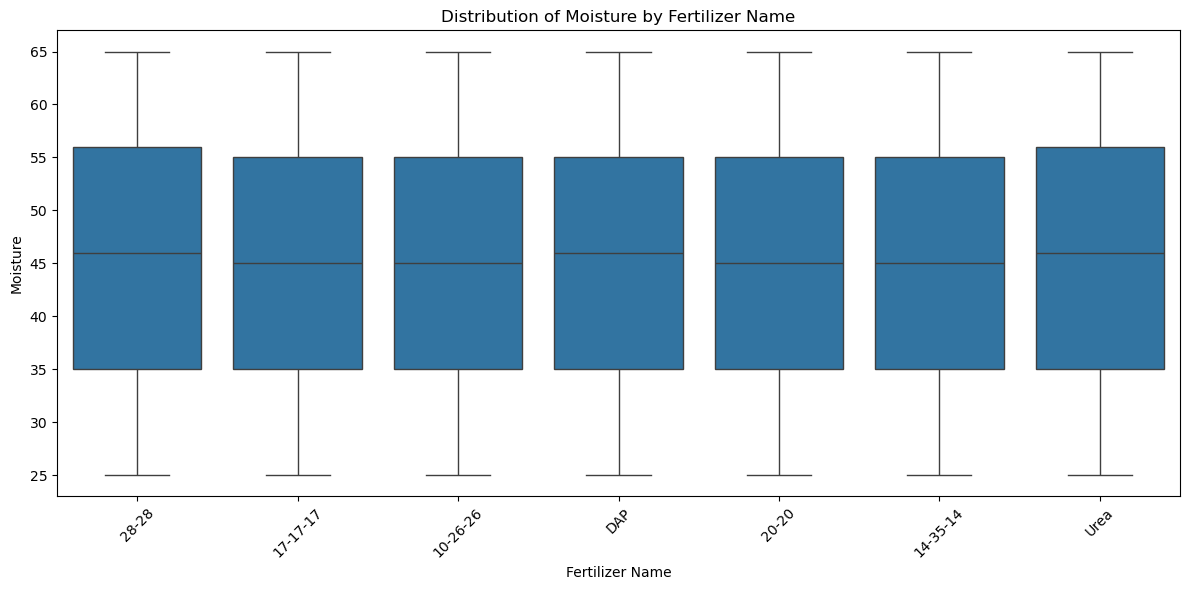

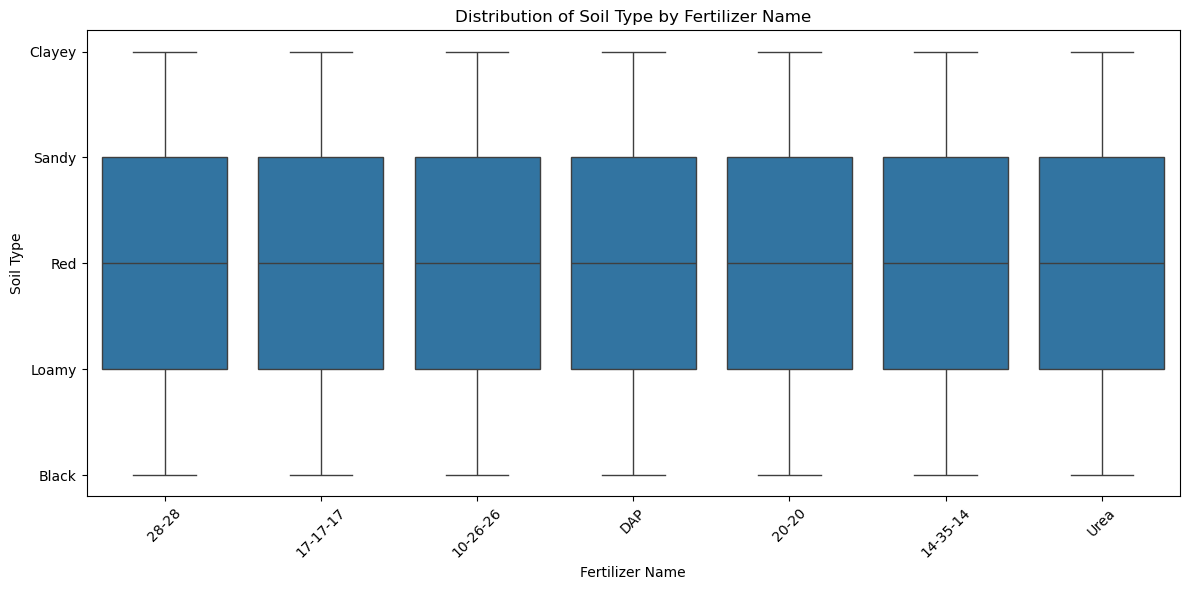

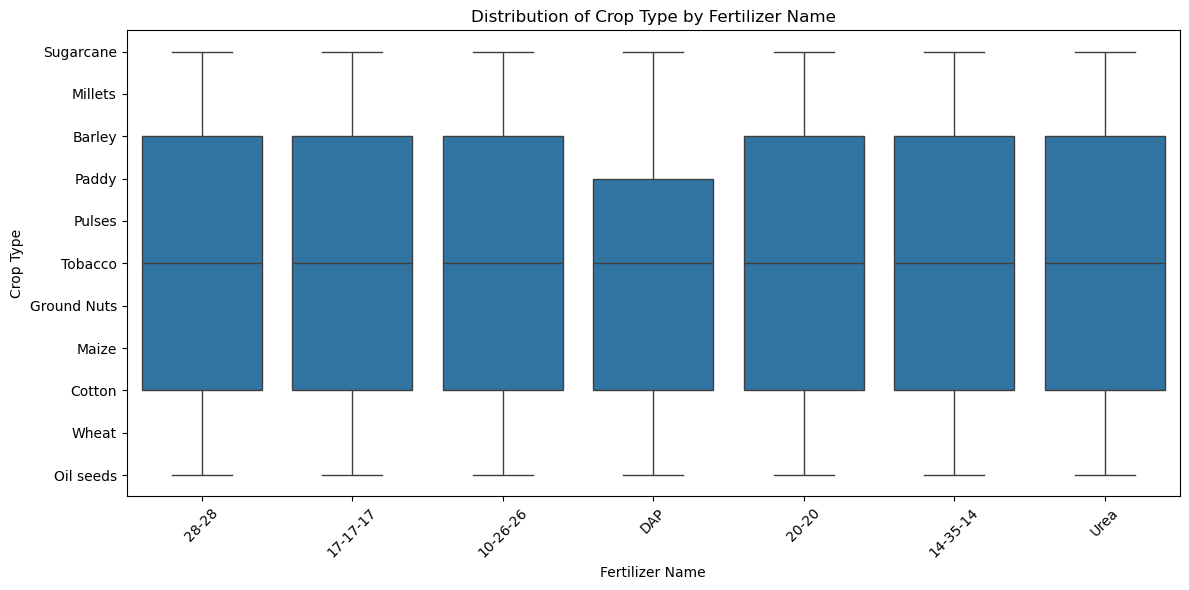

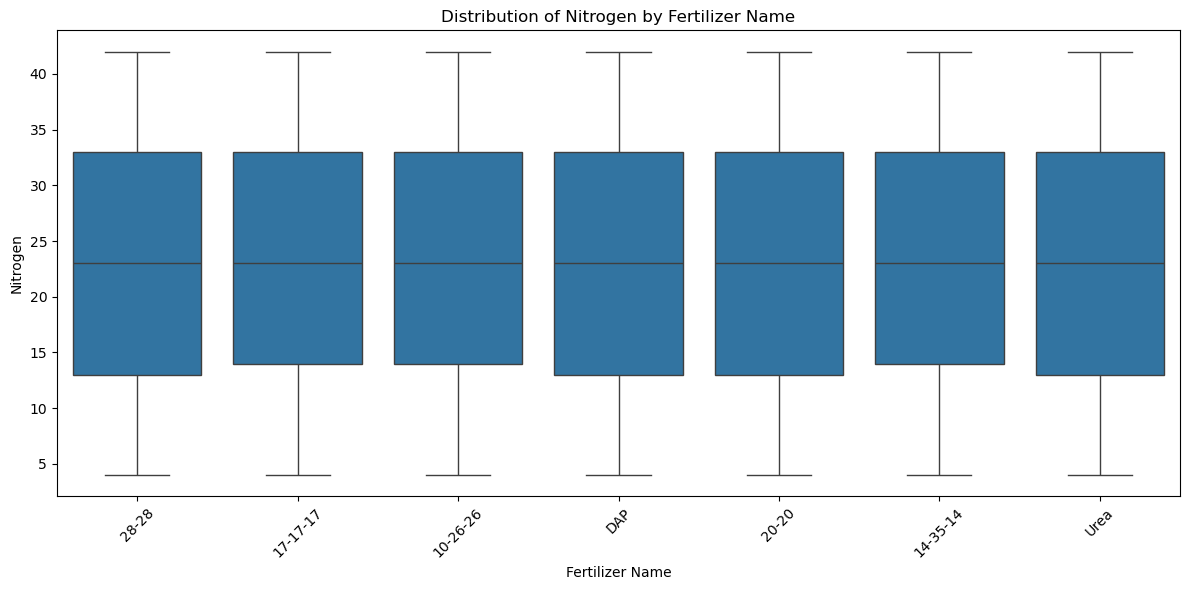

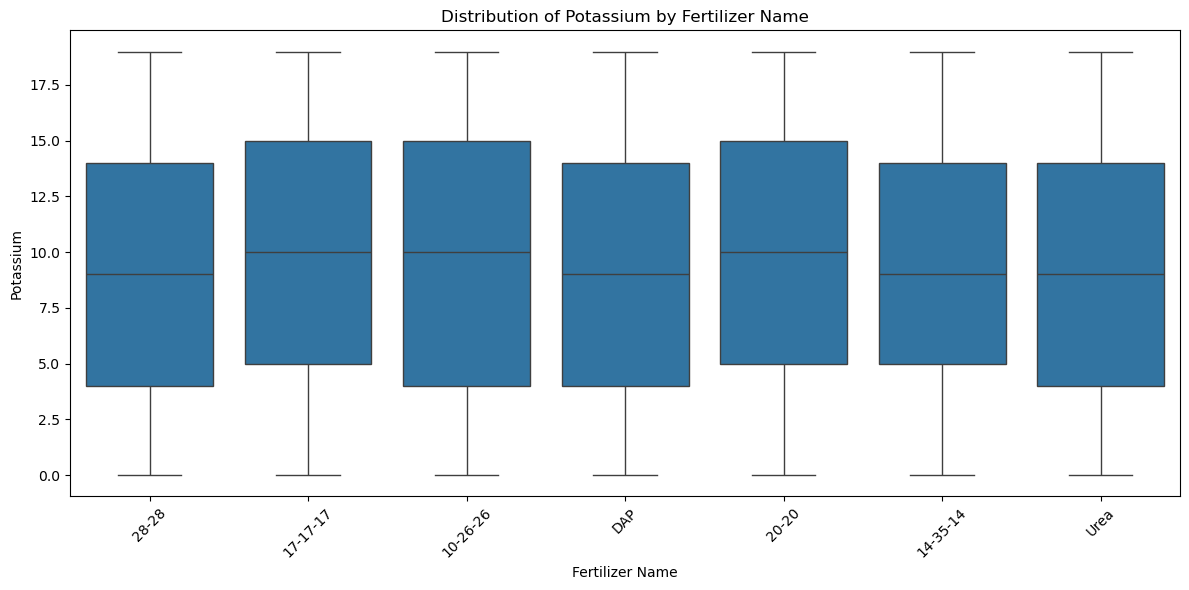

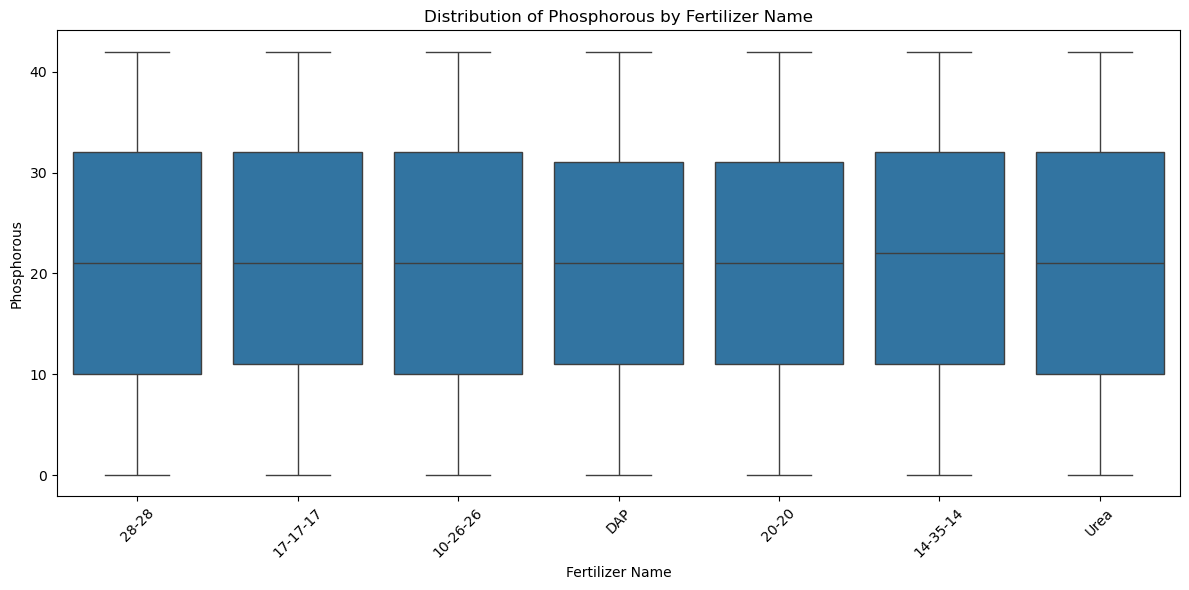

In [6]:
# For each column, plot the distribution of the values based on the Fertilizer Name, using boxplots.

for column in train_df.columns:
    if column != "Fertilizer Name":
        plt.figure(figsize=(12, 6))
        sns.boxplot(x="Fertilizer Name", y=column, data=train_df)
        plt.title(f"Distribution of {column} by Fertilizer Name")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [7]:
train_df.columns

Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')

In [8]:
# Count how many rows have same  ["Temparature","Humidity", "Moisture", "Soil Type", "Crop Type", "Nitrogen", "Potassium", "Phosphorous",]

count_df = (
    train_df.groupby(
        [
            "Temparature",
            "Humidity",
            "Moisture",
            "Soil Type",
            "Crop Type",
            "Nitrogen",
            "Potassium",
            "Phosphorous",
        ]
    )
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)

count_df[count_df["count"] > 1]

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,count


## Bin continuous variables

In [9]:
train_df = pd.concat(
    [
        train_df
        for _ in range(10)
    ]
).reset_index(drop=True)

In [10]:
from sklearn.preprocessing import KBinsDiscretizer


In [11]:
train_df_binned: pd.DataFrame = train_df.copy()

continuous_features = [
    "Temparature",
    "Humidity",
    "Moisture",
    "Nitrogen",
    "Potassium",
    "Phosphorous",
]

discretizers = {
    feature: KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform").fit(
        train_df_binned[[feature]]
    )
    for feature in continuous_features
}

for feature in continuous_features:
    train_df_binned[f"{feature}_binned"] = discretizers[feature].transform(
        train_df_binned[[feature]]
    )

# Apply binning (choose one method)
for col in ["Soil Type", "Crop Type", "Fertilizer Name"]:
    train_df_binned[col] = train_df_binned[col].astype("category")

# Check the binned features
for feature in continuous_features:
    print(f"\n{feature} binning:")
    print(
        f"Original range: {train_df[feature].min():.2f} - {train_df[feature].max():.2f}"
    )
    print(
        f"Binned distribution:\n{train_df_binned[f'{feature}_binned'].value_counts().sort_index()}"
    )


Temparature binning:
Original range: 25.00 - 38.00
Binned distribution:
Temparature_binned
0.0    1614140
1.0    1594960
2.0    1075800
3.0    1618210
4.0    1596890
Name: count, dtype: int64

Humidity binning:
Original range: 50.00 - 72.00
Binned distribution:
Humidity_binned
0.0    1635820
1.0    1275450
2.0    1625010
3.0    1323160
4.0    1640560
Name: count, dtype: int64

Moisture binning:
Original range: 25.00 - 65.00
Binned distribution:
Moisture_binned
0.0    1404550
1.0    1473400
2.0    1484440
3.0    1461610
4.0    1676000
Name: count, dtype: int64

Nitrogen binning:
Original range: 4.00 - 42.00
Binned distribution:
Nitrogen_binned
0.0    1507510
1.0    1542460
2.0    1369720
3.0    1529820
4.0    1550490
Name: count, dtype: int64

Potassium binning:
Original range: 0.00 - 19.00
Binned distribution:
Potassium_binned
0.0    1518470
1.0    1472790
2.0    1516510
3.0    1510150
4.0    1482080
Name: count, dtype: int64

Phosphorous binning:
Original range: 0.00 - 42.00
Binned d

In [12]:
train_df_binned.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,Temparature_binned,Humidity_binned,Moisture_binned,Nitrogen_binned,Potassium_binned,Phosphorous_binned
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,4.0,4.0,1.0,4.0,1.0,0.0
1,27,69,65,Sandy,Millets,30,6,18,28-28,0.0,4.0,4.0,3.0,1.0,2.0
2,29,63,32,Sandy,Millets,24,12,16,17-17-17,1.0,2.0,0.0,2.0,3.0,1.0
3,35,62,54,Sandy,Barley,39,12,4,10-26-26,3.0,2.0,3.0,4.0,3.0,0.0
4,35,58,43,Red,Paddy,37,2,16,DAP,3.0,1.0,2.0,4.0,0.0,1.0


# Train xgboost model

In [13]:
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [14]:
le = LabelEncoder()
y_encoded = le.fit_transform(train_df["Fertilizer Name"])
n_classes = len(le.classes_)

print(f"Number of classes: {n_classes}")

Number of classes: 7


In [15]:
feature_columns = [col for col in train_df_binned.columns if col != "Fertilizer Name"]
X = train_df_binned[feature_columns].copy()


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 6000000
Test set size: 1500000


## Train with custom objective (top-3 in this example)

# Simple xgboost model

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

params = {
    "objective": "multi:softmax",  # We'll override this with custom objective
    "num_class": n_classes,
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
}

dall = xgb.DMatrix(X, label=y_encoded, enable_categorical=True)

In [29]:
from typing import Tuple

def topk_objective(y_pred: np.ndarray, y_true: xgb.DMatrix, k=3)-> Tuple[np.ndarray, np.ndarray]:
    """
    Custom objective function for top-k classification

    Args:
        y_pred: predicted raw scores (1D array, needs reshaping)
        y_true: DMatrix with true labels
        k: number of top predictions to consider

    Returns:
        grad: gradient
        hess: hessian
    """
    # Get true labels from DMatrix
    labels = y_true.get_label()
    n_samples, _ = y_pred.shape
    # Convert to probabilities using softmax
    exp_pred = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
    probs = exp_pred / np.sum(exp_pred, axis=1, keepdims=True)

    # Initialize gradients and hessians
    grad = np.zeros_like(y_pred)
    hess = np.zeros_like(y_pred)

    for i in range(n_samples):
        true_class = int(labels[i])

        # Get top-k predicted classes
        top_k_indices = np.argsort(probs[i])[-k:]

        # Check if true class is in top-k
        if true_class in top_k_indices:
            # Reward: push true class probability higher
            grad[i, true_class] = -(1 - probs[i, true_class])
            hess[i, true_class] = probs[i, true_class] * (1 - probs[i, true_class])

            # Slightly penalize other top-k classes
            for j in top_k_indices:
                if j != true_class:
                    grad[i, j] = 0.1 * probs[i, j]
                    hess[i, j] = 0.1 * probs[i, j] * (1 - probs[i, j])
        else:
            # Penalty: push true class probability higher and top-k lower
            grad[i, true_class] = -(1 - probs[i, true_class])
            hess[i, true_class] = probs[i, true_class] * (1 - probs[i, true_class])

            # Penalize top-k predictions more heavily
            for j in top_k_indices:
                grad[i, j] = probs[i, j]
                hess[i, j] = probs[i, j] * (1 - probs[i, j])

    return grad.flatten(), hess.flatten()


def topk_eval_metric(y_pred: np.ndarray, y_true: xgb.DMatrix, k=3):
    """
    Custom evaluation metric for top-k accuracy

    Args:
        y_pred: predicted raw scores (1D array, needs reshaping)
        y_true: DMatrix with true labels
        k: number of top predictions to consider

    Returns:
        eval_name: name of the metric
        eval_result: metric value
    """
    # Get true labels from DMatrix
    labels = y_true.get_label()

    n_samples, _ = y_pred.shape

    # Convert to probabilities
    exp_pred = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
    probs = exp_pred / np.sum(exp_pred, axis=1, keepdims=True)

    # Calculate top-k accuracy
    correct = 0
    for i in range(n_samples):
        true_class = int(labels[i])
        top_k_indices = np.argsort(probs[i])[-k:]
        if true_class in top_k_indices:
            correct += 1

    accuracy = correct / n_samples
    return f"top{k}_accuracy", accuracy


In [30]:
import wandb
from wandb.integration.xgboost import WandbCallback
wandb.init(project="Predicting Optimal Fertilizers")

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [39]:
k = 3

model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"), (dtest, "test")],
    obj=lambda y_true, y_pred: topk_objective(y_true, y_pred, k=k),
    custom_metric=lambda y_true, y_pred: topk_eval_metric(y_true, y_pred, k=k),
    early_stopping_rounds=10,
    verbose_eval=10,
    callbacks=[WandbCallback(log_feature_importance=True, log_model=True)],
)
print(f"\nLabel encoder classes: {le.classes_}")
print(f"Number of classes: {n_classes}")

[0]	train-mlogloss:1.97694	train-top3_accuracy:0.45228	test-mlogloss:1.97694	test-top3_accuracy:0.45228


KeyboardInterrupt: 

In [ ]:
test_df = pd.read_csv("./data/test.csv", index_col="id")

# Transform test data using the same preprocessing steps
for feature in continuous_features:
    test_df[f"{feature}_binned"] = discretizers[feature].transform(test_df[[feature]])

for col in test_df.columns:
    if col in ["Soil Type", "Crop Type", "Fertilizer Name"]:
        test_df[col] = test_df[col].astype("category")


test_df

In [ ]:
test_df.dtypes

In [ ]:
test_dmatrix = xgb.DMatrix(test_df[feature_columns], enable_categorical=True)


In [ ]:
output = model.predict(test_dmatrix)
output_classes = le.inverse_transform(output.astype(int))

submission_df = pd.DataFrame({
    "id": test_df.index,
    "Fertilizer Name": output_classes
})

submission_df.to_csv("./data/submission.csv", index=False)
print("Submission file created: ./data/submission.csv")

In [ ]:
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

! kaggle competitions submit -c playground-series-s5e6 -f ./data/submission.csv -m "Submission at {now} with top-{k} objective and evaluation metric"
print("Submission sent to Kaggle.")